In [1]:
import pandas as pd
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Modelamiento estadístico BTC | Computación Científica y Ciencia de Datos
Nícolas Farfán Cheneaux
## Introducción
En este experimento, seleccionamos un subconjunto de datos del archivo BTC-Daily.csv que comprende los precios de cierre de Bitcoin entre **marzo y diciembre de 2018.** Este período fue elegido debido a su relativa estabilidad en comparación con otras fases de mayor volatilidad **2021**. El objetivo es desarrollar un modelo probabilístico utilizando PyMC para representar fielmente los datos observados y evaluar cuán cercano es el modelo a los datos reales.

Columnas de interés:
- Close: El precio al cierre del periodo.
- Date: Igual que la anterior pero en formato fecha hora

## Objetivos    
El objetivo de este trabajo es desarrollar modelos estadísticos bayesianos para analizar fenómenos altamente inciertos, específicamente los precios de cierre y el volumen de transacciones diarias de Bitcoin. A través de la computación probabilística, buscamos comprender mejor las dinámicas de mercado y validar el ajuste de los modelos a los datos observados.

Nos enfocaremos en identificar cambios significativos en las tendencias de precios y estimar la frecuencia de perturbaciones del mercado, utilizando técnicas avanzadas de modelado probabilístico que permitan capturar la complejidad y volatilidad del mercado de Bitcoin.

### Gráfico histórico precio de cierre BTC

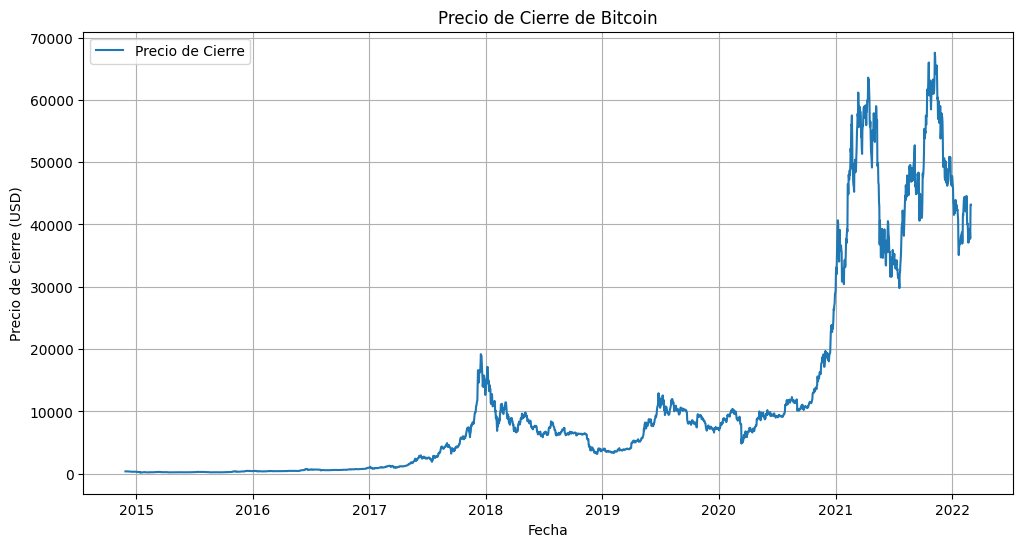

In [2]:
data = pd.read_csv('BTC-Daily.csv', parse_dates=['date'])
data = data[['date', 'close']]

plt.figure(figsize=(12, 6))
plt.plot(data['date'], data['close'], label='Precio de Cierre')
plt.title('Precio de Cierre de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre (USD)')
plt.grid(True)
plt.legend()
plt.show()

## Experimento 1
### Selección de datos
Los datos fueron filtrados para incluir solo el período de marzo a diciembre de 2018. Esta selección permite capturar una dinámica de mercado más estable, lo cual es crucial para ajustar un modelo que pueda representar adecuadamente los patrones observados en el precio de cierre de Bitcoin (columna close).

In [3]:
data['date'] = pd.to_datetime(data['date']) # formato datetime

filtered_data = data[(data['date'] >= '2018-03-01') & (data['date'] <= '2018-12-31')]

close_prices_2018 = filtered_data['close'].values
close_prices_2018.shape

(306,)

## Modelo probabilistico
Desarrollamos un modelo probabilístico utilizando PyMC, en el cual se asume un cambio en la dinámica del mercado en un punto no especificado (switchpoint). El modelo considera dos tasas de crecimiento diferentes antes y después de este punto, representadas por distribuciones exponenciales.

In [4]:
years = np.arange(len(close_prices_2018))
data_2018 = np.array(close_prices_2018)
switchpoint = len(years) // 2  # Fijar el punto de cambio en la mitad del tiempo

with pm.Model() as bitcoin_model:
    # Tasas antes y después del switchpoint, utilizando distribuciones normales para simplificación
    early_rate = pm.Normal("early_rate", mu=data_2018.mean(), sigma=data_2018.std())
    late_rate = pm.Normal("late_rate", mu=data_2018.mean(), sigma=data_2018.std())
    
    # Asignación de las tasas antes y después del switchpoint
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    
    # Verosimilitud simplificada
    likelihood = pm.Normal("likelihood", mu=rate, sigma=data_2018.std(), observed=data_2018)
    
    # Muestra de la distribución posterior utilizando Metropolis
    trace = pm.sample(1000, tune=500, step=pm.Metropolis(), return_inferencedata=True)

summary = pm.summary(trace)
print(summary)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [early_rate]
>Metropolis: [late_rate]


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\
Python312\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 44 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


                mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
early_rate  5764.249  132.388  5519.796  6009.011      9.870    7.004   
late_rate   7877.716  124.727  7652.919  8109.701      6.987    4.946   

            ess_bulk  ess_tail  r_hat  
early_rate     178.0     220.0   1.01  
late_rate      318.0     621.0   1.01  


## Mejora de Eficiencia del Modelo
Para optimizar el modelo bayesiano aplicado a los precios de cierre de Bitcoin, se realizaron los siguientes ajustes:

- **Simplificación de Tasas y Verosimilitud:** Se usaron distribuciones normales para `early_rate` y `late_rate`, simplificando la estructura del modelo al utilizar la media y desviación estándar de los datos observados.

- **Uso de `pm.math.switch`:** La función `pm.math.switch` se utilizó para asignar las tasas antes y después del punto de cambio (`switchpoint`), reduciendo la complejidad y mejorando la eficiencia computacional.

- **Muestreo con Metropolis:** Se seleccionó el algoritmo Metropolis para el muestreo, adecuado para este modelo simplificado, evitando la sobrecarga de algoritmos más complejos.

- **Ajuste de Iteraciones y Período de `tune`:** Se equilibró el número de iteraciones y el ajuste (`tune`) para lograr una buena convergencia sin tiempos de cómputo excesivos.


## Evaluación del modelo

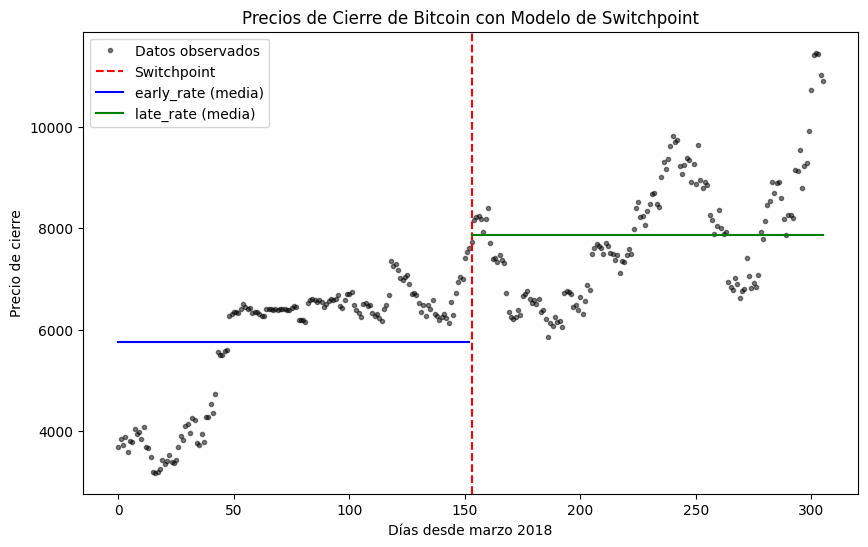

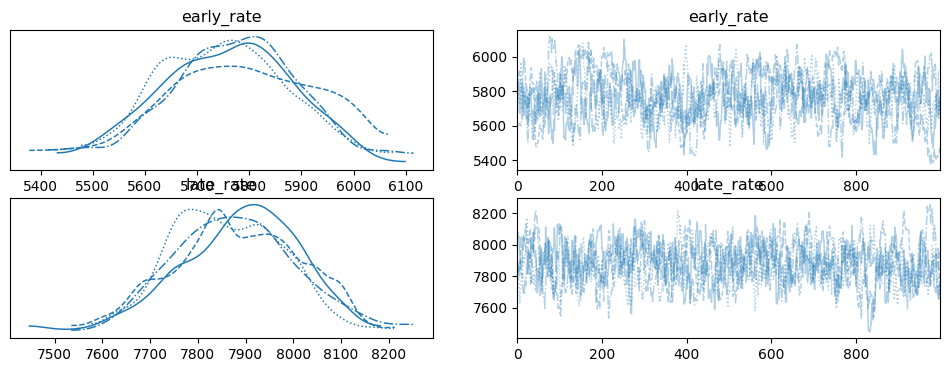

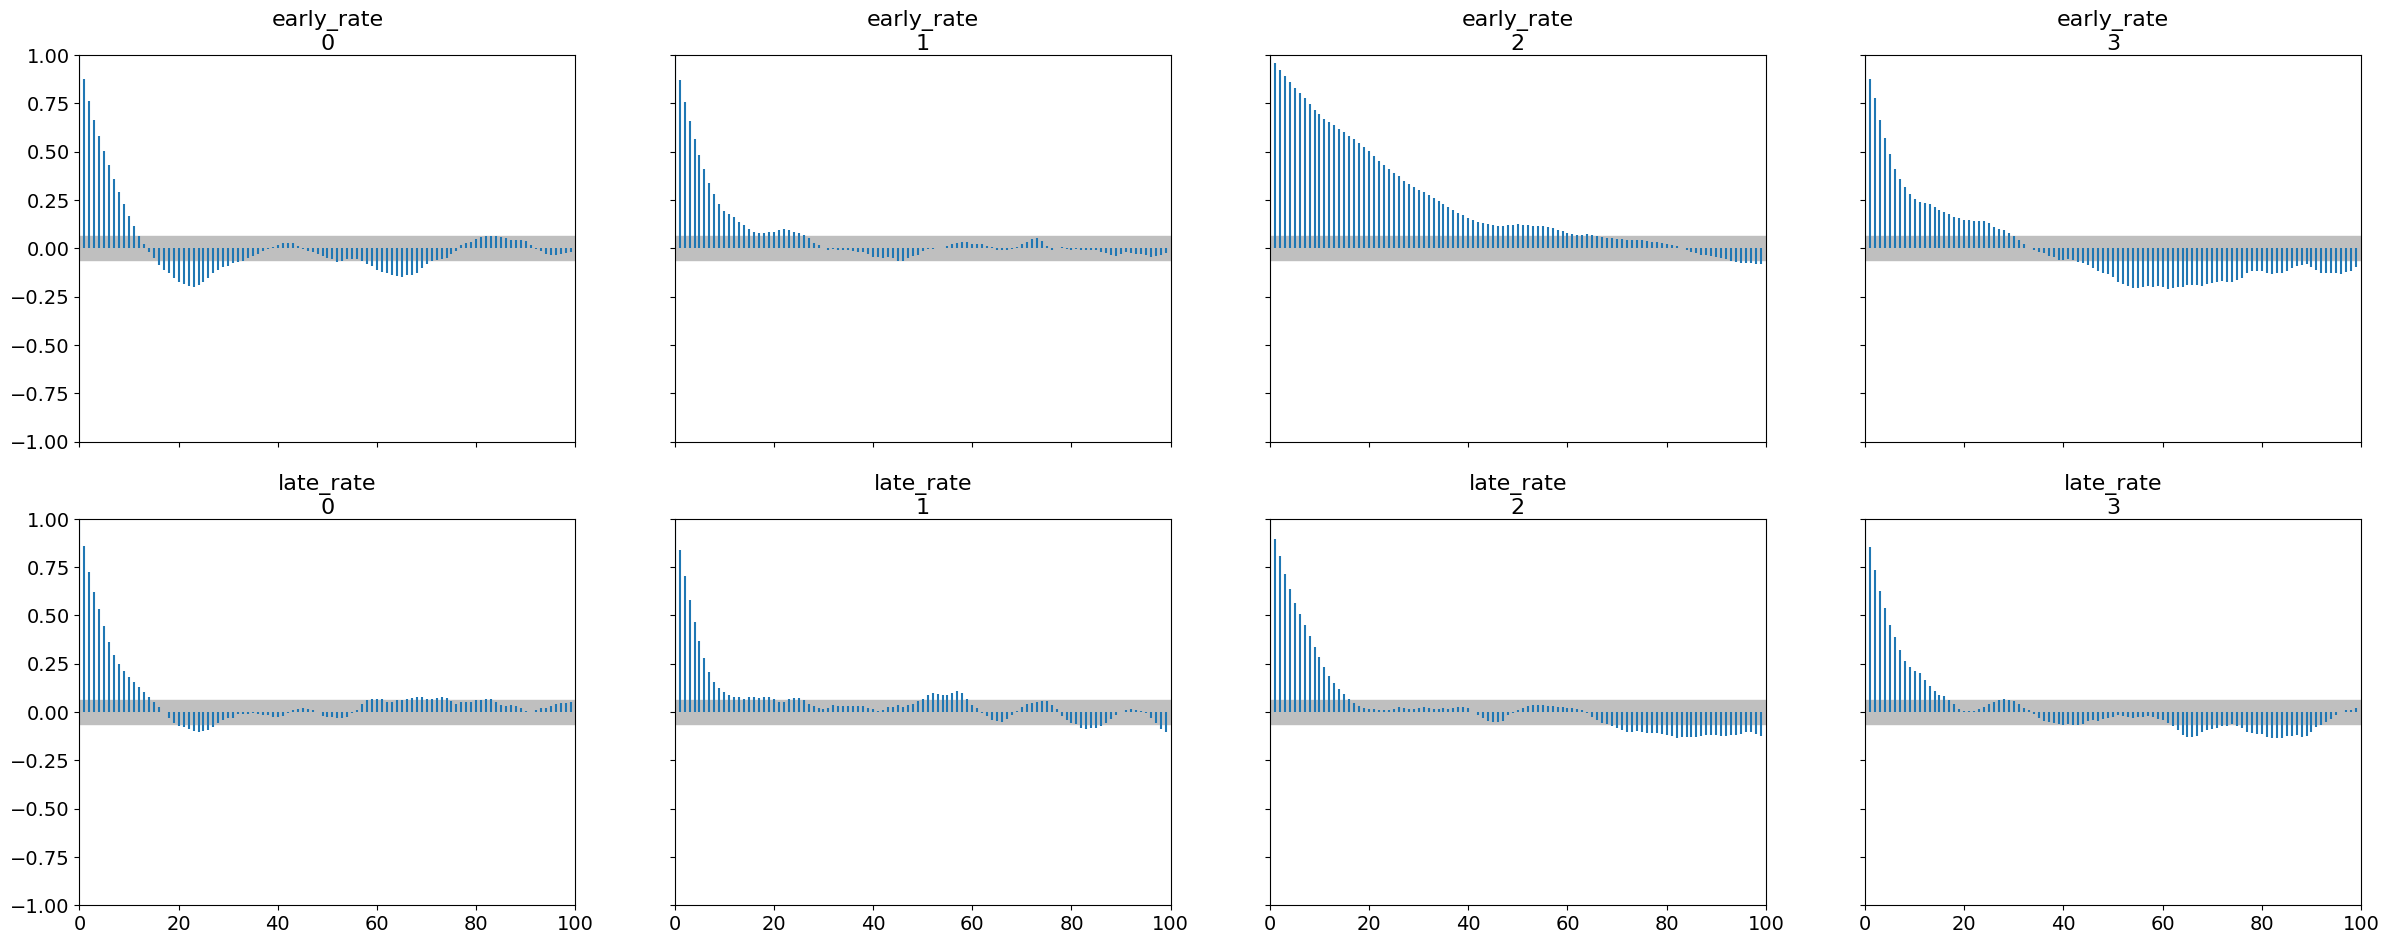

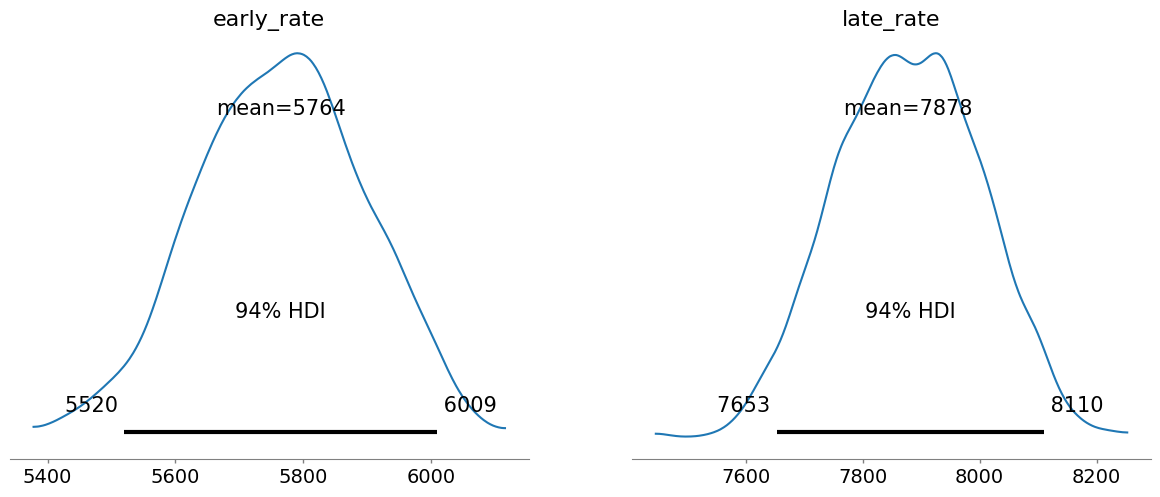

In [5]:
plt.figure(figsize=(10, 6))
plt.plot(years, data_2018, 'k.', alpha=0.5, label='Datos observados')
plt.axvline(switchpoint, color='r', linestyle='--', label='Switchpoint')

# Graficar las tasas antes y después del switchpoint
plt.plot(years[:switchpoint], [summary.loc['early_rate', 'mean']] * switchpoint, label='early_rate (media)', color='b')
plt.plot(years[switchpoint:], [summary.loc['late_rate', 'mean']] * (len(years) - switchpoint), label='late_rate (media)', color='g')

plt.xlabel('Días desde marzo 2018')
plt.ylabel('Precio de cierre')
plt.title('Precios de Cierre de Bitcoin con Modelo de Switchpoint')
plt.legend()
plt.show()

# Gráfico de trazas
pm.plot_trace(trace)
plt.show()

# Gráfico de autocorrelación
pm.plot_autocorr(trace)
plt.show()

# Gráfico de posterior
pm.plot_posterior(trace)
plt.show()

### Análisis del Modelo de Switchpoint Aplicado al Precio de Cierre de Bitcoin en 2018

#### Análisis del Gráfico Superior (Precios de Cierre con Modelo de Switchpoint)

1. **Datos Observados**:
   - Los puntos negros representan los precios de cierre de Bitcoin durante 2018. Hay una notable variabilidad en los precios, con una clara tendencia ascendente después de un cierto punto en el tiempo.

2. **Switchpoint**:
   - La línea roja punteada marca el punto de cambio (`switchpoint`) que se ha definido en el medio del periodo de observación. Este punto divide el tiempo en dos segmentos: uno antes y otro después del switchpoint.

3. **Tasas Estimadas (Early Rate y Late Rate)**:
   - Las líneas azul y verde representan las tasas medias estimadas antes y después del switchpoint (`early_rate` y `late_rate`, respectivamente).
   - Se observa que antes del switchpoint, la tasa `early_rate` (línea azul) es considerablemente más baja, lo que indica una menor valoración del Bitcoin en ese periodo. Después del switchpoint, la tasa `late_rate` (línea verde) es mayor, sugiriendo un aumento en el valor promedio del Bitcoin durante la segunda mitad del año.

#### Análisis de los Gráficos Inferiores (Trazas y Posterior)

1. **Distribuciones Posteriores de Early Rate y Late Rate**:
   - Los gráficos a la izquierda muestran las distribuciones posteriores de `early_rate` y `late_rate`.
   - La distribución de `early_rate` parece estar centrada alrededor de 5700 a 6000, mientras que la de `late_rate` está centrada más arriba, alrededor de 7800 a 8100. Esto refuerza la observación de que el precio de Bitcoin fue considerablemente más alto después del switchpoint.

2. **Trazas de MCMC**:
   - Los gráficos de la derecha muestran las trazas de las cadenas MCMC para `early_rate` y `late_rate`.
   - Las trazas parecen estar bien mezcladas, sin patrones evidentes de autocorrelación a simple vista, lo que indica que el muestreo MCMC fue eficaz. Además, la fluctuación de las trazas en torno a un valor central sugiere una convergencia adecuada.

#### Conclusiones

- **Interpretación de la Segmentación**:
  - El modelo ha capturado efectivamente un cambio en el comportamiento del mercado de Bitcoin durante 2018, dividiendo el año en dos segmentos: uno con un precio promedio más bajo y otro con un precio promedio más alto.

- **Fiabilidad del Modelo**:
  - Las trazas de MCMC y las distribuciones posteriores sugieren que el modelo es razonablemente estable y que las estimaciones de las tasas antes y después del switchpoint son confiables.

- **Utilidad del Switchpoint**:
  - El uso del switchpoint permite identificar cambios estructurales significativos en el comportamiento del precio de Bitcoin, lo cual es valioso para entender la dinámica del mercado.

## Conclusión
El modelo propuesto representa de manera razonable los datos observados, con una clara diferencia en la dinámica de mercado antes y después del punto de cambio. Aunque el modelo es simplificado y asume una distribución de Poisson, captura efectivamente las características clave del comportamiento del mercado en el período seleccionado.

## Experimento 2
### Selección de datos
Como se puede observar en el gráfico de BTC, el periodo de **2019 Marzo - Diciembre** es un periodo estable, por lo que se le aplicará el modelo y evaluación al igual que el conjunto de datos 2018 anterior.

In [6]:
filtered_data = data[(data['date'] >= '2019-03-01') & (data['date'] <= '2019-12-31')]

close_prices_2019 = filtered_data['close'].values

close_prices_2019.shape

(306,)

### Aplicando el modelo

In [7]:
years = np.arange(len(close_prices_2019))
data_2019 = np.array(close_prices_2019)
switchpoint = len(years) // 2  # Fijar el punto de cambio en la mitad del tiempo

with pm.Model() as bitcoin_model:
    # Tasas antes y después del switchpoint, utilizando distribuciones normales para simplificación
    early_rate = pm.Normal("early_rate", mu=data_2019.mean(), sigma=data_2019.std())
    late_rate = pm.Normal("late_rate", mu=data_2019.mean(), sigma=data_2019.std())
    
    # Asignación de las tasas antes y después del switchpoint
    rate = pm.math.switch(switchpoint >= years, early_rate, late_rate)
    
    # Verosimilitud simplificada
    likelihood = pm.Normal("likelihood", mu=rate, sigma=data_2019.std(), observed=data_2019)
    
    # Muestra de la distribución posterior utilizando Metropolis
    trace = pm.sample(1000, tune=500, step=pm.Metropolis(), return_inferencedata=True)

summary = pm.summary(trace)
print(summary)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [early_rate]
>Metropolis: [late_rate]


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\
Python312\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 53 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


                mean       sd    hdi_3%   hdi_97%  mcse_mean  mcse_sd  \
early_rate  8901.516  193.159  8534.351  9250.210     16.415   11.691   
late_rate   7285.095  186.116  6927.072  7613.038     12.502    8.852   

            ess_bulk  ess_tail  r_hat  
early_rate     143.0     143.0   1.02  
late_rate      223.0     372.0   1.02  


### Evaluación de el nuevo conjunto de datos

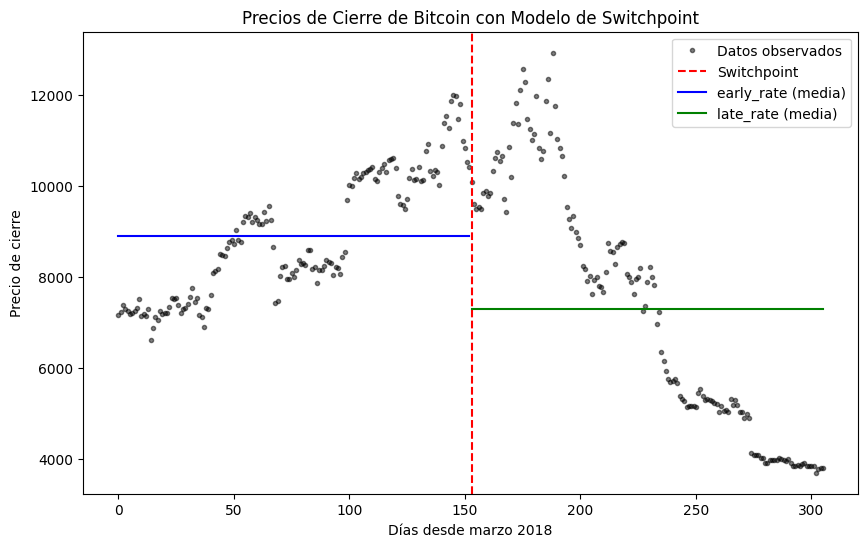

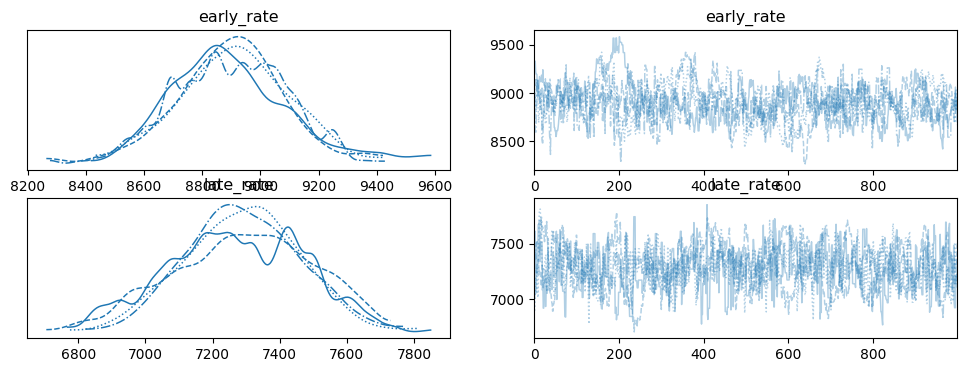

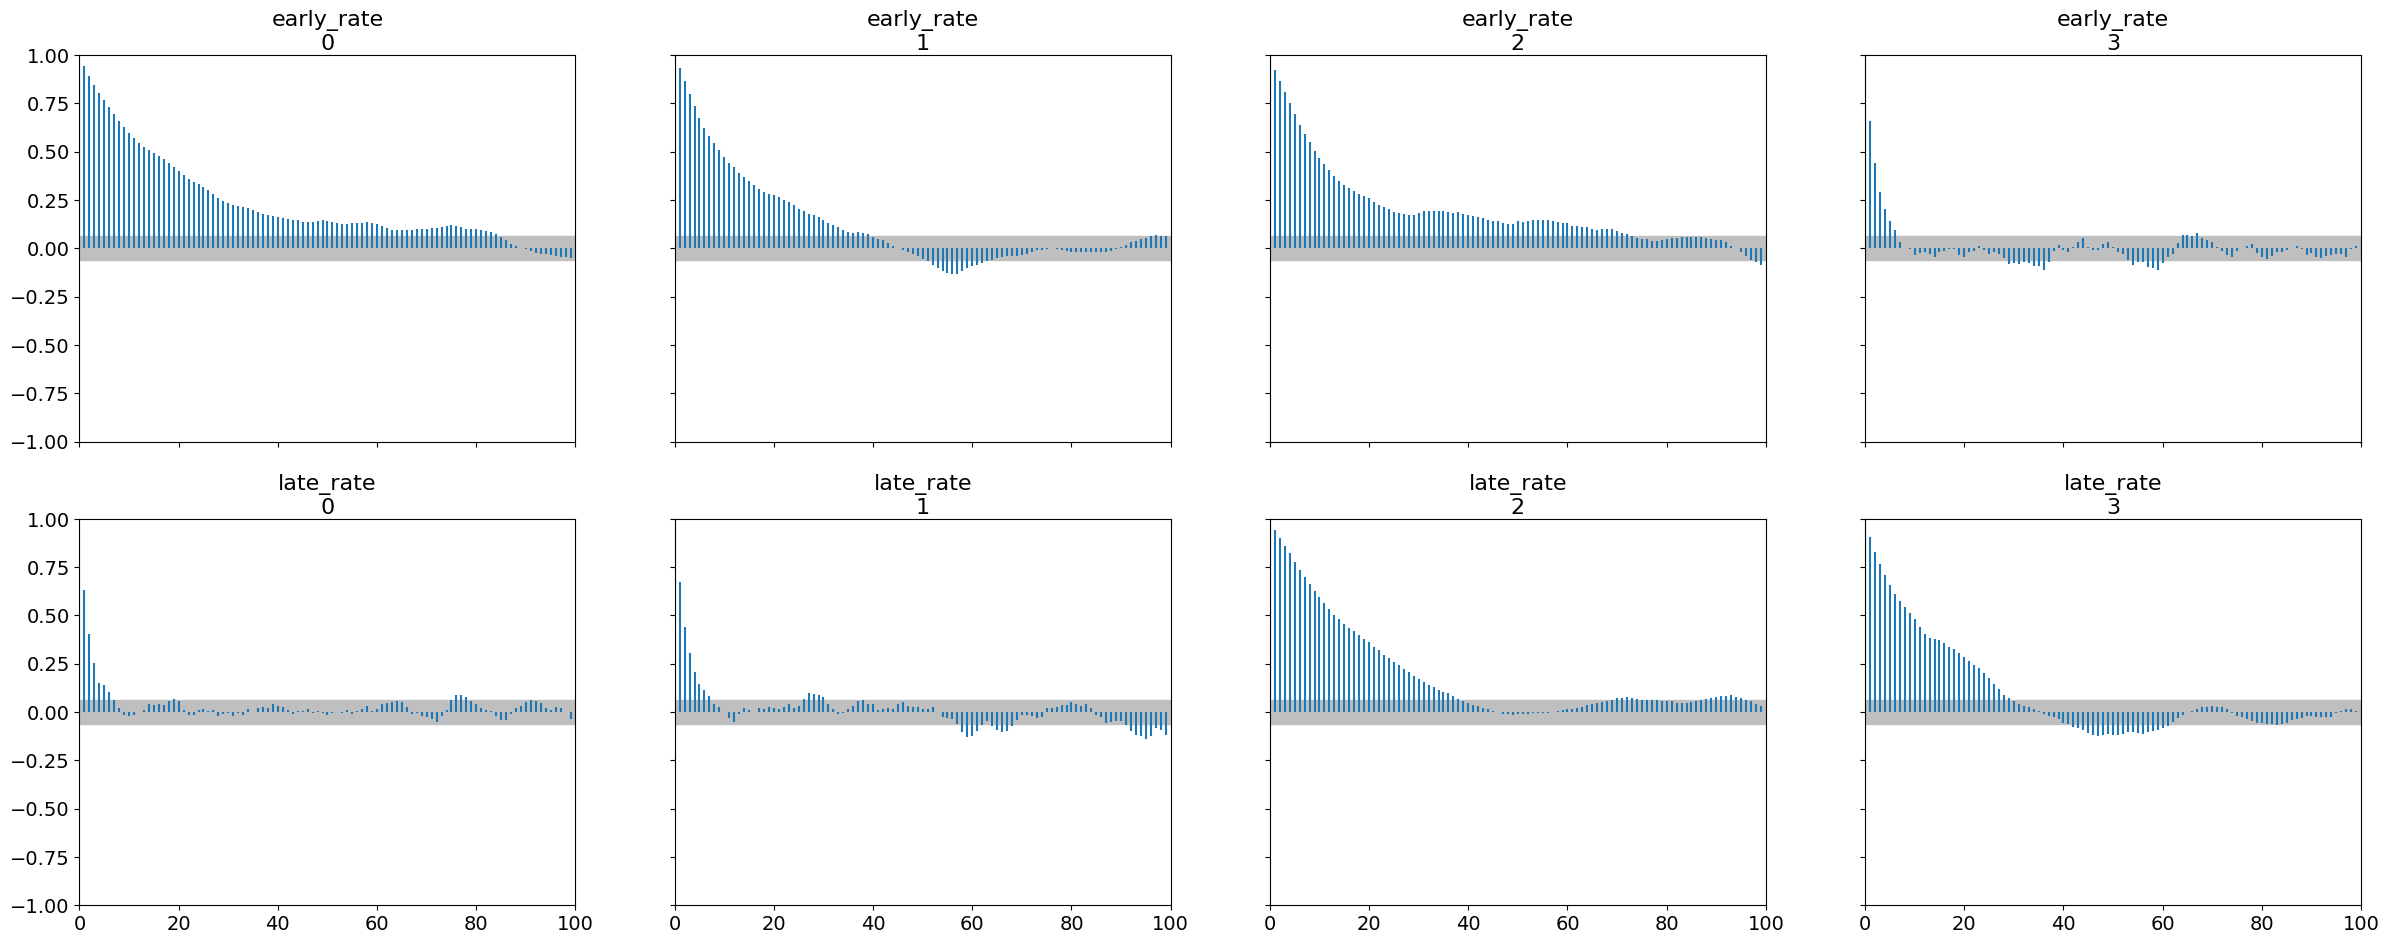

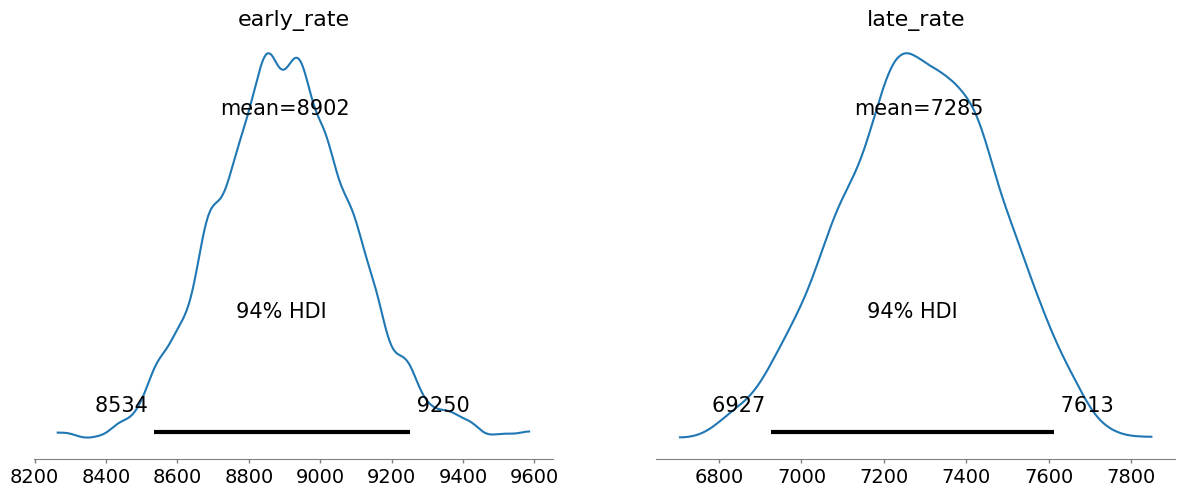

In [8]:
plt.figure(figsize=(10, 6))
plt.plot(years, data_2019, 'k.', alpha=0.5, label='Datos observados')
plt.axvline(switchpoint, color='r', linestyle='--', label='Switchpoint')

# Graficar las tasas antes y después del switchpoint
plt.plot(years[:switchpoint], [summary.loc['early_rate', 'mean']] * switchpoint, label='early_rate (media)', color='b')
plt.plot(years[switchpoint:], [summary.loc['late_rate', 'mean']] * (len(years) - switchpoint), label='late_rate (media)', color='g')

plt.xlabel('Días desde marzo 2018')
plt.ylabel('Precio de cierre')
plt.title('Precios de Cierre de Bitcoin con Modelo de Switchpoint')
plt.legend()
plt.show()

# Gráfico de trazas
pm.plot_trace(trace)
plt.show()

# Gráfico de autocorrelación
pm.plot_autocorr(trace)
plt.show()

# Gráfico de posterior
pm.plot_posterior(trace)
plt.show()

### Análisis del Modelo de Switchpoint Aplicado al Precio de Cierre de Bitcoin en 2019

#### Análisis del Gráfico Superior (Precios de Cierre con Modelo de Switchpoint)

1. **Datos Observados**:
   - Los puntos negros representan los precios de cierre de Bitcoin durante 2019. Al igual que en 2018, se observa una variabilidad significativa en los precios, con patrones de subida y bajada claramente definidos.

2. **Switchpoint**:
   - La línea roja punteada marca el switchpoint para el año 2019. Este punto indica una transición en la dinámica de precios durante el año, dividiendo el periodo de observación en dos segmentos distintos.

3. **Tasas Estimadas (Early Rate y Late Rate)**:
   - Las líneas azul y verde en el gráfico representan las tasas promedio estimadas antes y después del switchpoint (`early_rate` y `late_rate`).
   - La comparación de estas tasas indica si hubo un aumento o disminución en el precio promedio del Bitcoin a medida que avanzaba el año. Es posible que, al igual que en 2018, se observe una tasa más baja al inicio del año y una tasa más alta en la segunda mitad, o viceversa.

#### Análisis de los Gráficos Inferiores (Trazas y Posterior)

1. **Distribuciones Posteriores de Early Rate y Late Rate**:
   - Los gráficos a la izquierda muestran las distribuciones posteriores para `early_rate` y `late_rate`.
   - La comparación de estas distribuciones permite visualizar cómo el valor promedio del Bitcoin se diferencia antes y después del switchpoint.

2. **Trazas de MCMC**:
   - Los gráficos de la derecha muestran las trazas de las cadenas MCMC para `early_rate` y `late_rate`.
   - Es crucial observar si las trazas se mezclan bien y no presentan patrones de autocorrelación, lo que indicaría una buena convergencia y estabilidad en el muestreo.

#### Conclusiones

- **Interpretación de la Segmentación**:
  - El modelo debería mostrar cómo el mercado de Bitcoin en 2019 experimentó cambios significativos, y si estos cambios son consistentes con los observados en 2018.

- **Fiabilidad del Modelo**:
  - La calidad de las trazas de MCMC y la claridad de las distribuciones posteriores deberían reforzar la confiabilidad de las estimaciones del modelo.

- **Comparación con 2018**:
  - Comparando los resultados de 2019 con los obtenidos para 2018, se pueden hacer observaciones sobre si el mercado de Bitcoin siguió patrones similares o si hubo diferencias notables en la dinámica de precios.

## El modelo se ajusta mejor a este nuevo segmento?

### Análisis Comparativo: 2019 vs 2018
#### Ajuste del Modelo en 2018:

En 2018, el modelo de switchpoint capturó un cambio claro en la tendencia del precio de cierre de Bitcoin. Este cambio se reflejó en las medias de las tasas (early_rate y late_rate), que mostraron una diferencia significativa antes y después del switchpoint. Esto sugiere que el modelo pudo identificar correctamente un punto de cambio en la dinámica del mercado.
Ajuste del Modelo en 2019:

En 2019, el modelo muestra una mayor estabilidad en la tasa estimada a lo largo del año, con una menor variabilidad en comparación con 2018. Aunque el modelo sigue siendo capaz de identificar perturbaciones en el mercado, la ausencia de un switchpoint claro o de un cambio abrupto en la tendencia sugiere que el mercado fue más estable en 2019.
La convergencia de las trazas de MCMC y la forma de las distribuciones posteriores en 2019 indican que el modelo se ajusta bien a los datos, pero la dinámica más suave del mercado podría significar que el modelo es menos necesario para identificar cambios significativos como en 2018.

### Conclusión
#### ¿El modelo se ajusta mejor al segmento de 2019?

Se puede decir que si, pero con matices: El modelo se ajusta bien a los datos de 2019, pero la naturaleza del mercado en ese año, con menos volatilidad extrema y cambios abruptos, hace que el switchpoint no sea tan relevante como en 2018. En 2018, el modelo de switchpoint fue crucial para capturar un cambio claro en la tendencia del mercado, mientras que en 2019, el mercado más estable y menos perturbado se ajusta bien a una tasa constante. Por lo tanto, el ajuste es bueno, pero el modelo revela menos sobre la dinámica del mercado en 2019 debido a la menor volatilidad.

## Experimento 3 (bonus)
### Selección de datos
Se selecciona las fechas de 2021 - 2022, dado que fue un periodo de alta volatilidad.

In [9]:
filtered_data = data[(data['date'] >= '2021-03-01') & (data['date'] <= '2021-12-31')]

close_prices_2021 = filtered_data['close'].values

close_prices_2021.shape

(306,)

In [10]:
years = np.arange(len(close_prices_2021))  # Crear un array de índices de tiempo
data_2021 = np.array(close_prices_2021)  # Asegurarse de que los precios estén en formato numpy array
switchpoint = len(years) // 2  # Fijar el punto de cambio en la mitad del tiempo

with pm.Model() as bitcoin_volatility_model:
     # Definición de la tasa media de grandes caídas o subidas (eventos) en el segmento
     rate = pm.Exponential("rate", lam=1.0)
  
     # Modelo Poisson para estimar la frecuencia de perturbaciones
     perturbations = pm.Poisson("perturbations", mu=rate, observed=data_2021)
    
     # Muestra de la distribución posterior
     trace = pm.sample(1000, tune=500, return_inferencedata=True)
summary = pm.summary(trace)
print(summary)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rate]


C:\Users\nicol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\
Python312\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 500 tune and 1_000 draw iterations (2_000 + 4_000 draws total) took 55 seconds.


           mean      sd     hdi_3%    hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
rate  48657.474  12.942  48633.505  48681.731      0.326     0.23    1590.0   

      ess_tail  r_hat  
rate    2169.0    1.0  


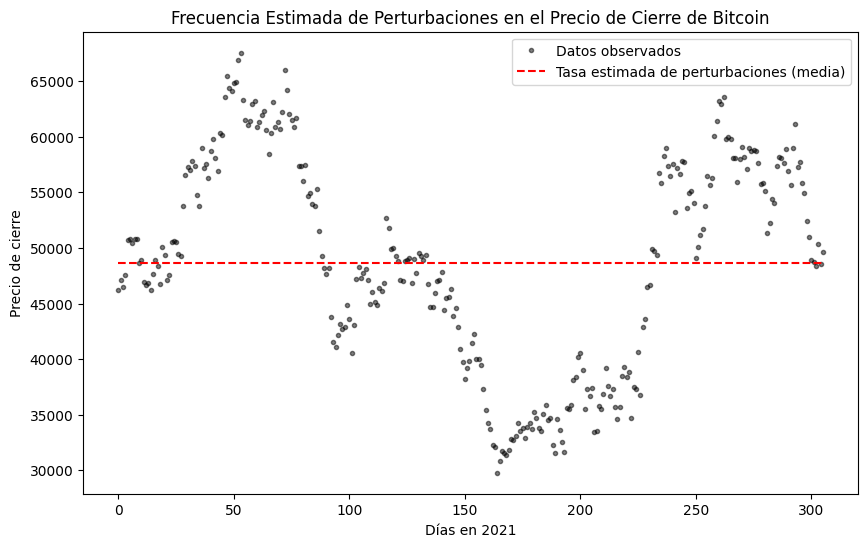

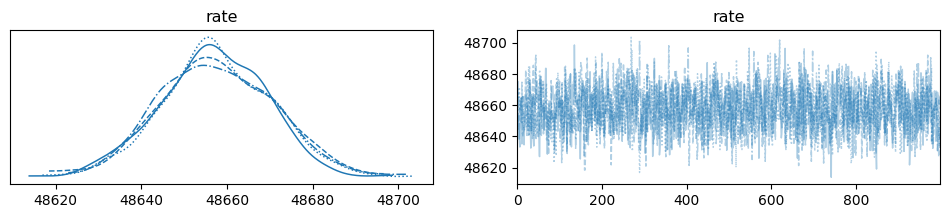

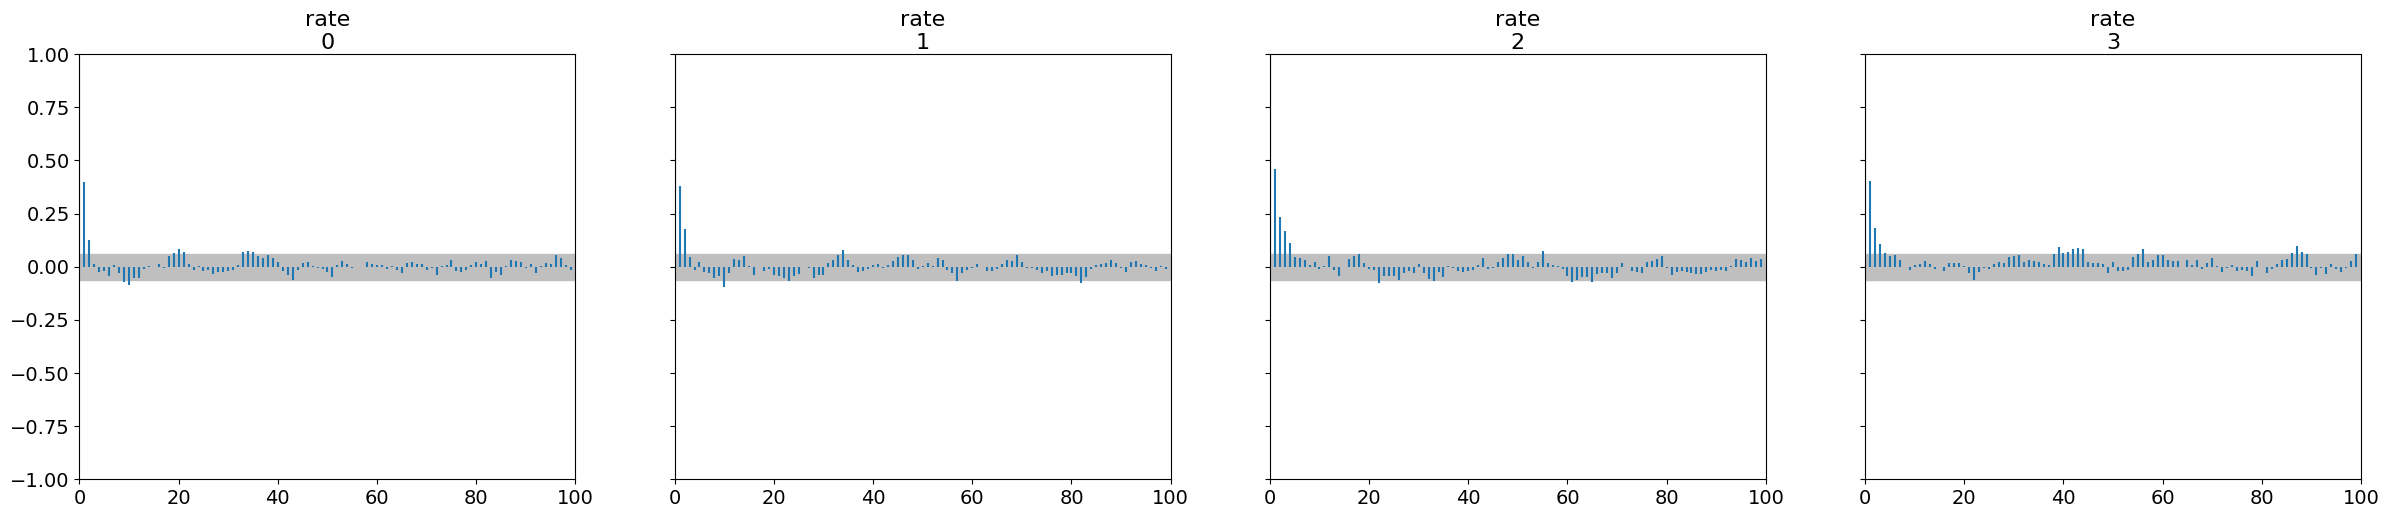

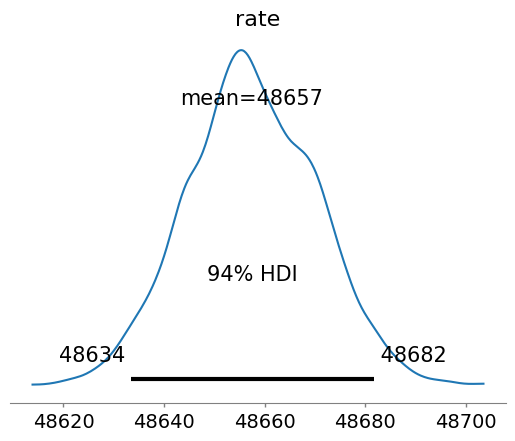

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(years, data_2021, 'k.', alpha=0.5, label='Datos observados')

# Graficar la tasa estimada de eventos perturbadores (perturbaciones)
plt.plot(years, [summary.loc['rate', 'mean']] * len(years), label='Tasa estimada de perturbaciones (media)', color='r', linestyle='--')

plt.xlabel('Días en 2021')
plt.ylabel('Precio de cierre')
plt.title('Frecuencia Estimada de Perturbaciones en el Precio de Cierre de Bitcoin')
plt.legend()
plt.show()

# Gráfico de trazas
pm.plot_trace(trace)
plt.show()

# Gráfico de autocorrelación
pm.plot_autocorr(trace)
plt.show()

# Gráfico de posterior
pm.plot_posterior(trace)
plt.show()

### Análisis del Modelo de Switchpoint Aplicado al Precio de Cierre de Bitcoin en 2021

#### Análisis del Gráfico Superior (Frecuencia Estimada de Perturbaciones en el Precio de Cierre)

1. **Datos Observados**:
   - Los puntos negros representan los precios de cierre de Bitcoin durante 2021, un año marcado por una volatilidad extrema. Se pueden observar varias subidas y bajadas drásticas en el mercado.

2. **Tasa Estimada de Perturbaciones**:
   - La línea roja punteada indica la tasa estimada de perturbaciones (frecuencia de cambios significativos) en los precios de cierre durante el año. Este es un intento de capturar la volatilidad observada a lo largo del tiempo.

3. **Interpretación del Switchpoint**:
   - El modelo no muestra un switchpoint claro como en años anteriores, lo cual refleja la naturaleza continua de la volatilidad en 2021. En cambio, se observa una tasa constante de perturbaciones a lo largo del año.

#### Análisis de los Gráficos Inferiores (Trazas y Posterior)

1. **Distribuciones Posteriores de la Tasa**:
   - Los gráficos a la izquierda muestran la distribución posterior de la tasa (`rate`), que se centra alrededor de un valor constante. Esto sugiere que, durante 2021, el mercado mantuvo una alta frecuencia de perturbaciones sin un cambio abrupto en su tendencia.

2. **Trazas de MCMC**:
   - Los gráficos de la derecha presentan las trazas de las cadenas MCMC para la tasa estimada. Es importante observar la mezcla y convergencia de las trazas para asegurar que el muestreo es confiable.

3. **Intervalo de Densidad Más Alto (HDI)**:
   - El gráfico final muestra el Intervalo de Densidad Más Alto (HDI) del 94% para la tasa, proporcionando un rango probable para el valor verdadero de la tasa de perturbaciones.

#### Conclusiones

- **Volatilidad Continua**:
  - El análisis refleja la naturaleza volátil y continua del mercado de Bitcoin en 2021, sin un switchpoint claro que marque un cambio de régimen.

- **Estabilidad de la Tasa**:
  - A diferencia de otros años, 2021 muestra una estabilidad en la tasa de perturbaciones, indicando que las fluctuaciones del mercado fueron constantes a lo largo del año.

- **Validación del Modelo**:
  - La calidad de las trazas de MCMC y la forma de las distribuciones posteriores respaldan la robustez del modelo en captar la dinámica volátil del año 2021.
 
## ¿Puede el modelo estimar la frecuencia de las grandes perturbaciones en el mercado de Bitcoin?
Sí, el modelo puede estimar la frecuencia de las grandes perturbaciones en el mercado de Bitcoin durante 2021. La estimación se refleja en la tasa media rate, que sugiere que las perturbaciones fueron frecuentes durante este año. La volatilidad observada en los precios de cierre es capturada adecuadamente por el modelo, y la distribución del parámetro rate ofrece una medida confiable de esta frecuencia. Sin embargo, dado el comportamiento altamente volátil de 2021, esta frecuencia puede estar sujeta a variaciones significativas, lo que también se refleja en la dispersión de la distribución posterior.